#https://github.com/cornellius-gp/gpytorch/issues/1743
#[Question] Implementing multi-output multi-task approximate GP #1743

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [2]:
import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats


In [3]:
class MultiOutputMultiTaskGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        #batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
                       
        #self._validate_tensor_args(X=train_X, Y=train_Y)

        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

## DOE Data

In [4]:
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df = pd.read_csv('data/dps-cleaned-missing.csv')
print(len(df))
df.head()

1843


,Import_Date,ISID,Project,Protein,Modality,Control_Type,Stress_Condition,Temp_C_,Time_Days_,Well_ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified_Excipients,1st_Excipient_in_Sample,2nd_Excipient_in_Sample,_Conc_for_Excipient1,Origin_of_data
0,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B02,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
1,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B03,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
2,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B04,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
3,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B05,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
4,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B06,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary


In [5]:
cols_group = ['Project','Protein','Modality', 'Stress_Condition','Temp_C_', 'Time_Days_']
cols_feature01 = ['Buffer','NaCl_mM_', 'pH']
cols_feature02 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']
#cols_target = ['UP_SEC_Monomer','UP_SEC_HMW']
cols_target = ['UP_SEC_Monomer','UP_SEC_LMW']
cols_cate = ['Buffer','NaClRange','PS80_Range','Sucrose_Range','Trehalose_Range']

30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


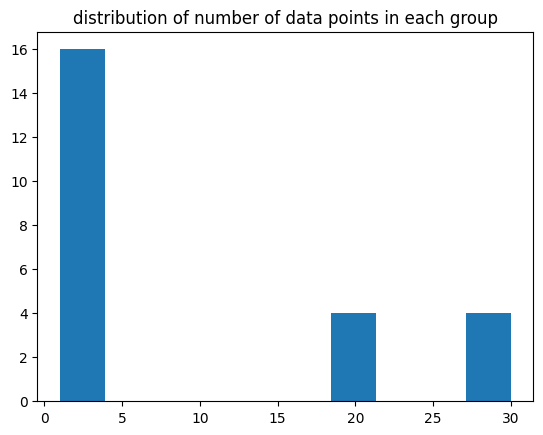

In [6]:
# split dataframe by identifiers
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits_identifier = list(df[cols_group + cols_feature01+cols_target].groupby(cols_group,dropna=is_drop_na))
#splits_identifier = list(df[cols_group + cols_cate+['pH']+cols_target].groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits_identifier]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

In [7]:
split1 = splits_identifier[1]
split3 = splits_identifier[3]
split5 = splits_identifier[5]

split1_formulation_df = split1[1][cols_feature01]
split1_formulation_df.reset_index(drop = True,inplace =True)
split3_formulation_df = split3[1][cols_feature01]
split3_formulation_df.reset_index(drop = True,inplace =True)
split5_formulation_df = split5[1][cols_feature01]
split5_formulation_df.reset_index(drop = True,inplace =True)


print(split1_formulation_df.equals(split3_formulation_df))
print(split3_formulation_df.equals(split5_formulation_df))

split1_target_df = split1[1][cols_target]
split1_target_df.reset_index(drop = True,inplace =True)
#split1_target_df.columns = [c+'_1' for c in split1_target_df.columns]

split3_target_df = split3[1][cols_target]
split3_target_df.reset_index(drop = True,inplace =True)
#split3_target_df.columns = [c+'_3' for c in split3_target_df.columns]

split5_target_df = split5[1][cols_target]
split5_target_df.reset_index(drop = True,inplace =True)
#split5_target_df.columns = [c+'_5' for c in split5_target_df.columns]


True
True


In [8]:
#input space 8==9==11 != 10
split8 = splits_identifier[8]
split9 = splits_identifier[9]
split10 = splits_identifier[10]
split11 = splits_identifier[11]

split8_formulation_df = split8[1][cols_feature01]
split8_formulation_df.reset_index(drop = True,inplace =True)
split9_formulation_df = split9[1][cols_feature01]
split9_formulation_df.reset_index(drop = True,inplace =True)
split10_formulation_df = split10[1][cols_feature01]
split10_formulation_df.reset_index(drop = True,inplace =True)
split11_formulation_df = split11[1][cols_feature01]
split11_formulation_df.reset_index(drop = True,inplace =True)

print('----does 8 equal 9---')
print(split8_formulation_df.equals(split9_formulation_df)) 
print('----does 8 equal 10---')
print(split8_formulation_df.equals(split10_formulation_df))
print('----does 8 equal 11---')
print(split8_formulation_df.equals(split11_formulation_df))
print('----does 9 equal 10---')
print(split9_formulation_df.equals(split10_formulation_df))
print('----does 9 equal 11---')
print(split9_formulation_df.equals(split11_formulation_df))
print('----does 10 equal 11---')
print(split10_formulation_df.equals(split11_formulation_df))#! split 10 has a different input than 8,9,11

split8_target_df = split8[1][cols_target]
split8_target_df.reset_index(drop = True,inplace =True)
#split8_target_df.columns = [c+'_8' for c in split8_target_df.columns]

split9_target_df = split9[1][cols_target]
split9_target_df.reset_index(drop = True,inplace =True)
#split9_target_df.columns = [c+'_9' for c in split9_target_df.columns]

split10_target_df = split10[1][cols_target]
split10_target_df.reset_index(drop = True,inplace =True)
#split10_target_df.columns = [c+'_10' for c in split10_target_df.columns]

split11_target_df = split11[1][cols_target]
split11_target_df.reset_index(drop = True,inplace =True)
#split11_target_df.columns = [c+'_11' for c in split11_target_df.columns]

----does 8 equal 9---
True
----does 8 equal 10---
False
----does 8 equal 11---
True
----does 9 equal 10---
False
----does 9 equal 11---
True
----does 10 equal 11---
False


In [9]:
def remove_col_outlier(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    keep_inds = ~((df[col] < (Q1 - 2 * IQR)) |(df[col] > (Q3 + 2 * IQR)))
    df = df[keep_inds]
    return df,keep_inds

In [10]:

split1_target_df,keep1_inds = remove_col_outlier(split1_target_df,cols_target[1])
split3_target_df,keep3_inds = remove_col_outlier(split3_target_df,cols_target[1])
split5_target_df,keep5_inds = remove_col_outlier(split5_target_df,cols_target[1])

split1_formulation_df = split1_formulation_df[(keep1_inds)]
split3_formulation_df = split3_formulation_df[(keep3_inds)]
split5_formulation_df = split5_formulation_df[(keep5_inds)]

print(split1_formulation_df.shape)
print(split3_formulation_df.shape)
print(split5_formulation_df.shape)

split8_target_df,keep8_inds = remove_col_outlier(split8_target_df,cols_target[1])
split9_target_df,keep9_inds = remove_col_outlier(split9_target_df,cols_target[1])
split10_target_df,keep10_inds = remove_col_outlier(split10_target_df,cols_target[1])
split11_target_df,keep11_inds = remove_col_outlier(split11_target_df,cols_target[1])


split8_formulation_df = split8_formulation_df[(keep8_inds)]
split9_formulation_df = split9_formulation_df[(keep9_inds)]
split10_formulation_df = split10_formulation_df[(keep10_inds)]
split11_formulation_df = split11_formulation_df[(keep11_inds)]

print(split8_formulation_df.shape)
print(split9_formulation_df.shape)
print(split10_formulation_df.shape)
print(split11_formulation_df.shape)



(21, 3)
(18, 3)
(21, 3)
(30, 3)
(29, 3)
(29, 3)
(26, 3)


In [11]:
ls_df_x = [split8_formulation_df,split9_formulation_df,split10_formulation_df,split11_formulation_df]
for i,tmp_df_x in enumerate(ls_df_x):
        tmp_df_x['task_ind'] = i
df_x = pd.concat(ls_df_x)
df_x.reset_index(inplace=True, drop = True)
df_x

,Buffer,NaCl_mM_,pH,task_ind
0,Acetate,0,4.5,0
1,Acetate,0,5.0,0
2,Acetate,0,5.6,0
3,Acetate,0,6.2,0
4,Citrate,0,5.6,0
...,...,...,...,...
109,Acetate,150,5.6,3
110,Acetate,150,6.2,3
111,Citrate,150,5.6,3
112,Citrate,150,6.2,3


In [12]:
ls_df_y = [split8_target_df,split9_target_df,split10_target_df,split11_target_df]
df_y = pd.concat(ls_df_y,axis = 0)
df_y.reset_index(inplace = True, drop = True)
df_y

,UP_SEC_Monomer,UP_SEC_LMW
0,90.71,9.29
1,90.70,9.30
2,90.64,9.36
3,90.65,9.35
4,91.04,8.96
...,...,...
109,89.97,9.99
110,90.10,9.90
111,90.15,9.85
112,90.02,9.98


In [13]:
#convert Buffer column to labels
x_name = 'Buffer'
labels, categories = factorize(df_x[x_name])
df_x[x_name+"_label"] = labels


#onehot encoding
n30_total_df = pd.get_dummies(df_x, columns = ['Buffer'])
print(n30_total_df.head())

df_x['Buffer_Acetate'] = n30_total_df['Buffer_Acetate'].astype(int)
df_x['Buffer_Citrate'] = n30_total_df['Buffer_Citrate'].astype(int)
df_x['Buffer_Histidine'] = n30_total_df['Buffer_Histidine'].astype(int)
print(df_x.head())

   NaCl_mM_   pH  task_ind  Buffer_label  Buffer_Acetate  Buffer_Citrate  \
0         0  4.5         0             0            True           False   
1         0  5.0         0             0            True           False   
2         0  5.6         0             0            True           False   
3         0  6.2         0             0            True           False   
4         0  5.6         0             1           False            True   

   Buffer_Histidine  
0             False  
1             False  
2             False  
3             False  
4             False  
    Buffer  NaCl_mM_   pH  task_ind  Buffer_label  Buffer_Acetate  \
0  Acetate         0  4.5         0             0               1   
1  Acetate         0  5.0         0             0               1   
2  Acetate         0  5.6         0             0               1   
3  Acetate         0  6.2         0             0               1   
4  Citrate         0  5.6         0             1               0 

In [92]:
from sklearn.cluster import KMeans
x_name = 'NaCl_mM_'
best_n_clusters = 3
km = KMeans(n_clusters=best_n_clusters, random_state=10)
kmeans = km.fit(df_x[[x_name]])
df_x[x_name+"_label"] = kmeans.labels_

In [93]:
ls_model = ['rf','simpleGP-sklearn','simpleGP-gpytorch','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust', 'y-norm-sklearn']
ls_n_cate = ['no-cate','one-cate']
ls_cate_transform = ['label','ohe','LVGP','partial-LMGP','partial-LMGP-per-task','full-LMGP-per-task']
ls_output_rank_option = [0,1,2]
ls_task_rank_option = [0,1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_stratify_task = ['not-stratify','stratify-x']

In [94]:
#model_option = 'rf'
#model_option = 'simpleGP'
model_option = 'multi-task-single-output'
#model_option = 'multi-task-multi-output'
x_scale_option = 'x-minmax'
y_scale_option = 'y-minmax' #GaussianProcessRegressor has a normalize_y argument


#cate_option = cols_feature.difference(['NaCl_mM_','Trehalose_w_v_'])
#cate_option = cols_feature
#cate_option = cols_feature.difference(['NaCl_mM_'])
cate_option = ['Buffer','NaCl_mM_']
if len(cate_option) > 0:
        #cate_transform_option = 'full-LMGP-per-task'
        #cate_transform_option = 'partial-LMGP-per-task'
        cate_transform_option = 'label'
else:
        cate_transform_option = ''
if model_option != 'simpleGP':
        output_rank_option = 2
        task_rank_option = 4
        lik_rank_option = 1
else:
        output_rank_option = ''
        lik_rank_option = ''
        task_rank_option = ''

#stratify_option = 'stratify-x'

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_label = 'n_cate_var_'+str(len(cate_option))
cate_transform_label = 'cate_transform_'+cate_transform_option
if model_option != 'simpleGP':
        output_rank_label = 'output_rank_'+str(output_rank_option)
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        output_rank_label = str(output_rank_option)
        task_rank_label = str(task_rank_option)
        lik_rank_label = str(lik_rank_option)

"""

remove_pred_outlier_label = 'remove_pred_outlier_'+str(remove_pred_outlier_option)



split_label = split_option
stratify_label = stratify_option
"""

#folder_name = '-'.join([model_label,task_rank_label,output_rank_label,lik_rank_label,x_scale_label,y_scale_label,cate_transform_label,
#                        remove_pred_outlier_label,split_label,stratify_label])

folder_name = '-'.join([model_label,output_rank_label,task_rank_label,lik_rank_label,
                        x_scale_label,y_scale_label,cate_label,cate_transform_label])

figPath = 'output/dpsdata-0815/'+folder_name

if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder output/dpsdata-0815/multi-task-single-output-output_rank_2-task_rank_4-lik_rank_1-x-minmax-y-minmax-n_cate_var_2-cate_transform_label


In [95]:
##Split the data into training and testing sets
cols_feature = cols_feature01
s = set(cate_option)
cols_numeric = [x for x in cols_feature if x not in s]
cols_numeric

if len(cate_option) == 0:
    cols_cate = []
    cols_feature_new = cols_feature
else:
    cols_cate = [x + '_label' for x in cate_option]
    cols_feature_new = cols_cate + list(cols_numeric) + ['task_ind']

cols_target = list(df_y.columns)

df_x_select = df_x[cols_feature_new]


df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x_select, df_y, test_size=0.2, random_state=0,stratify=df_x_select['task_ind'])

In [97]:
from sklearn.compose import ColumnTransformer
#cols_exception = []
cols_exception = cols_cate + ['task_ind']
if x_scale_label == 'x-minmax':
    xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),
                          df_X_train.columns.difference(cols_exception))], 
                         remainder = 'passthrough')

    scaled_X_train=xct.fit_transform(df_X_train) 
    scaled_X_test=xct.transform(df_X_test)

    t_train_x = torch.Tensor(scaled_X_train)
    t_test_x = torch.Tensor(scaled_X_test)
elif x_scale_label == 'no-x-scale':
    scaled_X_train=df_X_train.to_numpy()
    scaled_X_test=df_X_test.to_numpy()

    t_train_x = torch.Tensor(df_X_train.to_numpy())
    t_test_x = torch.Tensor(df_X_test.to_numpy())

##multi-task

In [98]:
# We will use the simplest form of GP model, exact inference
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [99]:
#M3GPR-O
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_tasks, rank = 0):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=rank
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [100]:
#M3GPR-R
class MultiOutputMultiTaskGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        #batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
                       
        #self._validate_tensor_args(X=train_X, Y=train_Y)

        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [101]:
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    #scaled_y_test = df_y_test.to_numpy()

t_train_y = torch.Tensor(scaled_y_train)

In [102]:
num_outputs = t_train_y.shape[-1]

task_rank = task_rank_option
output_rank = output_rank_option
lik_rank = lik_rank_option
if lik_rank is None:
            lik_rank = output_rank

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                rank=lik_rank if lik_rank is not None else 0,
            )

model = MultiOutputMultiTaskGP(t_train_x, t_train_y,likelihood,
                               task_rank = task_rank,output_rank = output_rank)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Inte

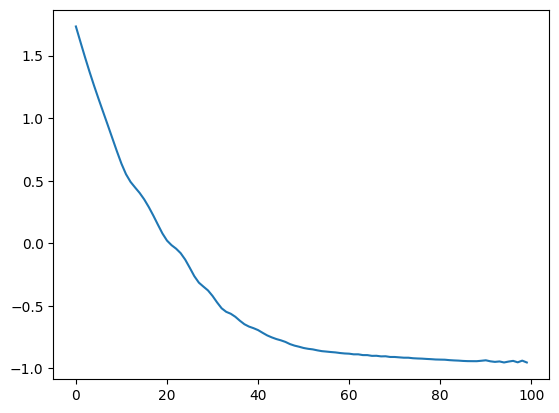

In [103]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
ls_loss = []
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    ls_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()
plt.plot(ls_loss)

In [104]:
t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [105]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

        #t_std_train = train_mean - train_lower
        #t_std_test = test_mean - test_lower

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Int

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [106]:
if y_scale_option=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()

    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_97080/3187160543.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_97080/3187160543.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_97080/3187160543.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/

         Task_1_Output_1  Task_1_Output_2  Task_2_Output_1  Task_2_Output_2  \
MAE                 1.38             0.20             0.47             0.33   
MAE2                0.53             0.13             0.53             0.32   
MSE                 5.25             0.07             0.26             0.13   
RMSE                2.29             0.27             0.51             0.36   
MAPE                0.02             0.02             0.01             0.03   
MAXE                5.23             0.46             0.72             0.53   
EVS               -58.97             0.47             0.56             0.81   
R2                -72.92             0.34             0.55             0.78   
AVG_STD             1.90             1.02             1.49             0.89   
MIN_STD             1.45             0.91             1.32             0.84   
MAX_STD             2.46             1.12             1.84             0.94   

         Task_3_Output_1  Task_3_Output_2  Task_4_O

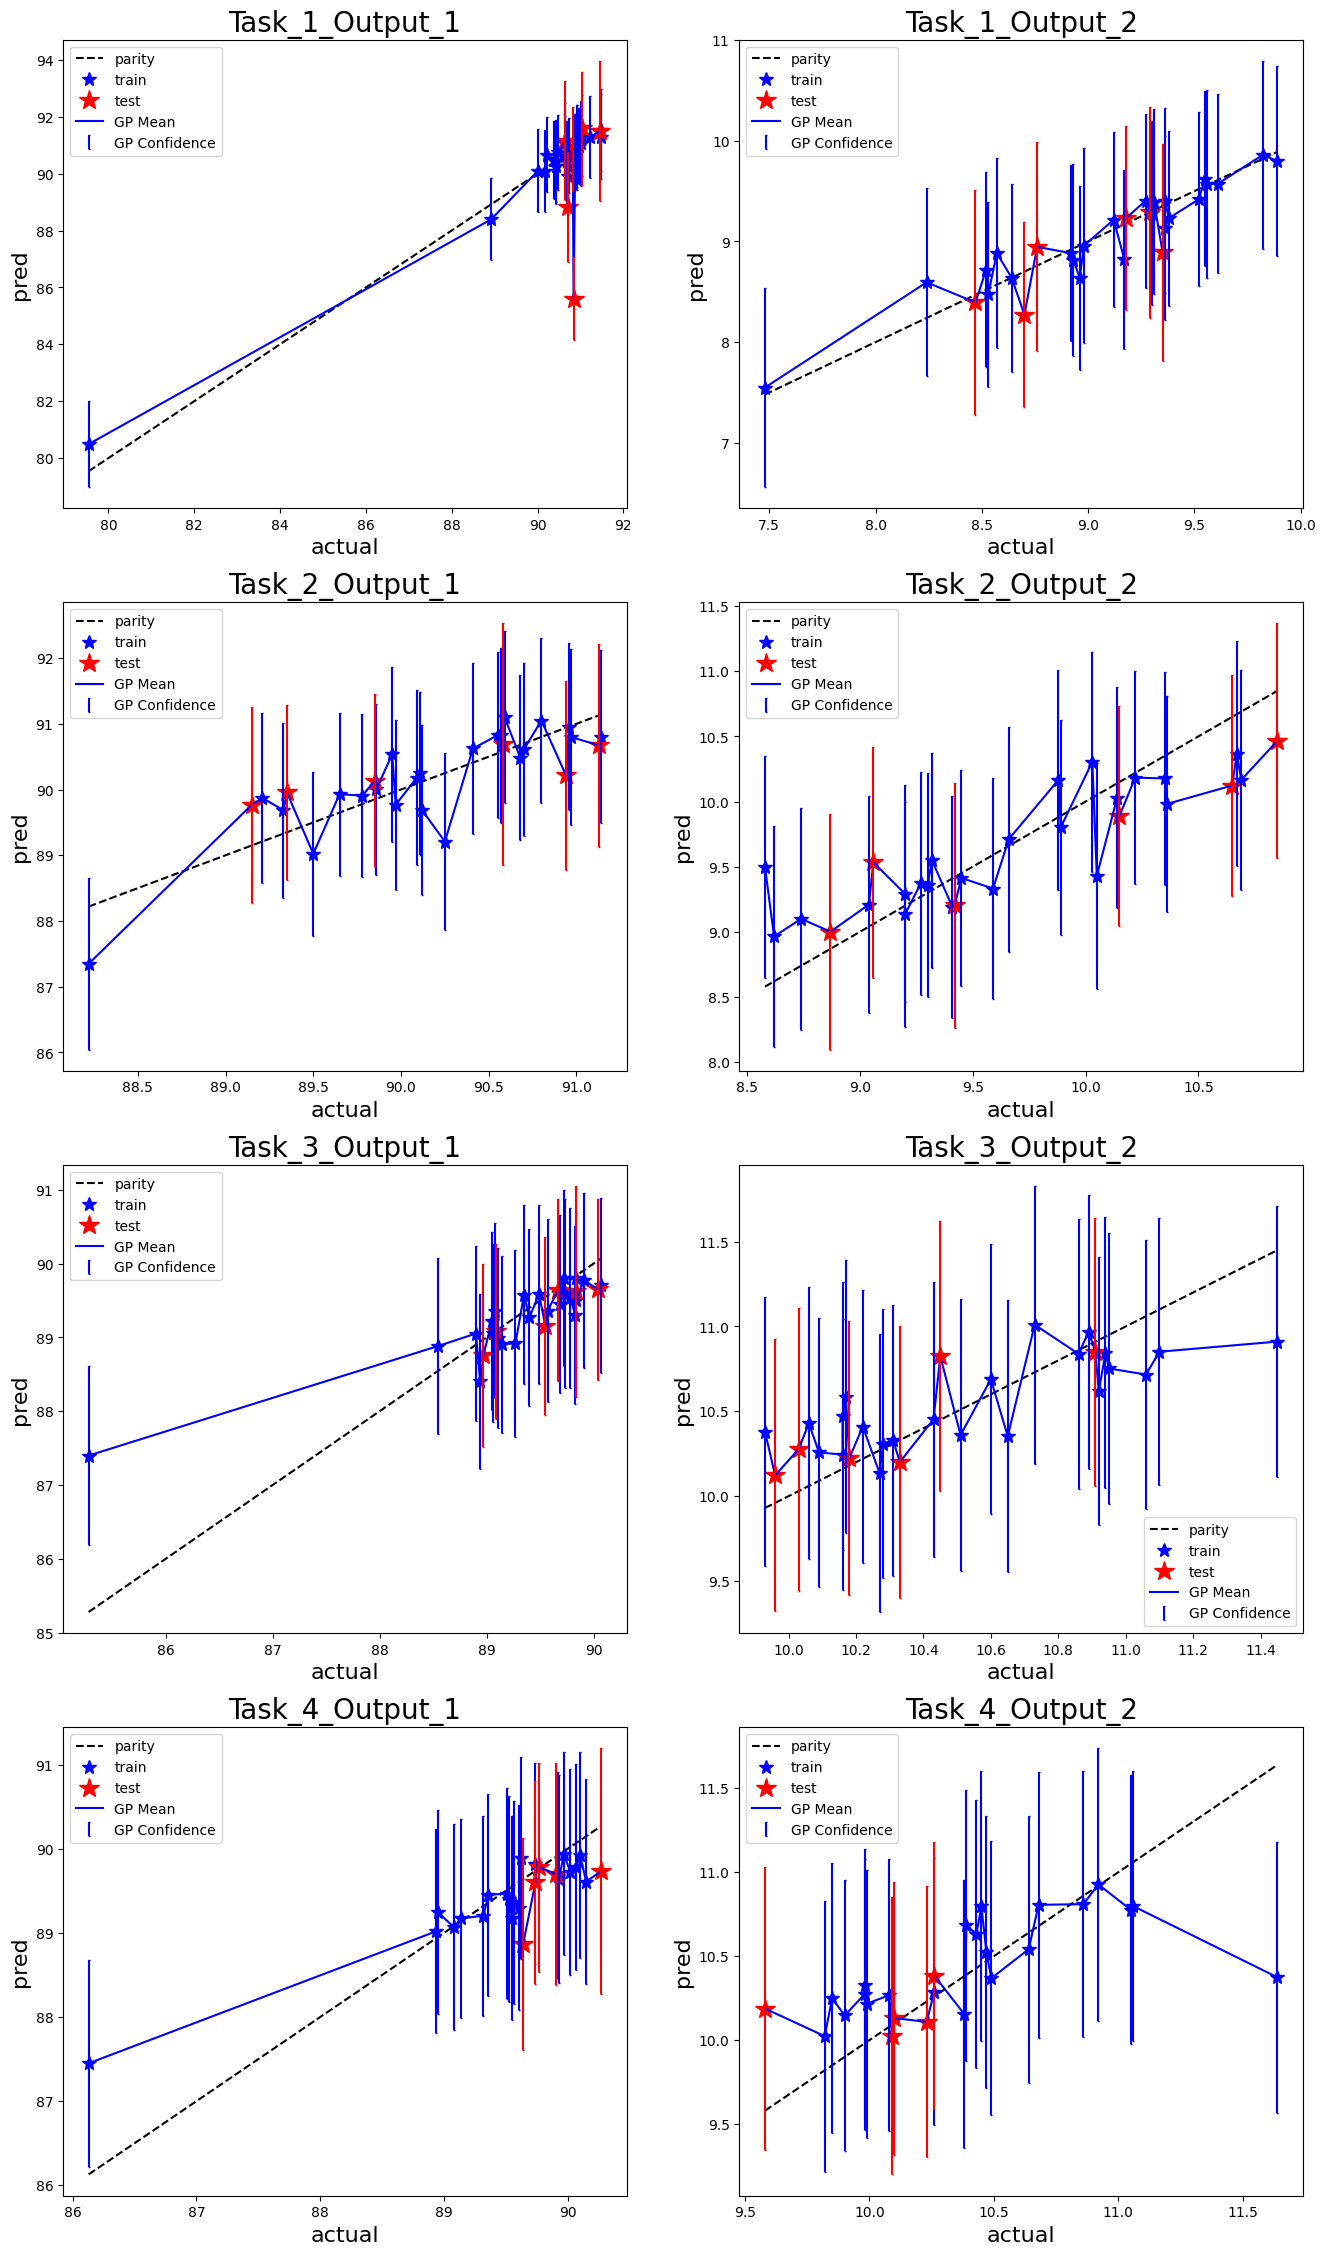

In [107]:
#from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_wide = []

plot_axis_lb = df_y.min(axis = 0) - 0.4 * df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4 * df_y.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = len(cols_target)
num_tasks = len(ls_df_x)

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = 'Task_'+str(task_ind+1) + '_Output_'+str(j+1)
    cols_target_wide.append(tmp_col_y)

    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    #y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_title('Task_'+str(task_ind+1) + '_Output_'+str(j+1),fontsize=20)
    y_axes[a].set_xlabel('actual',fontsize=16)
    y_axes[a].set_ylabel('pred',fontsize=16)

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

## Generate Synthetic data

In [108]:
from scipy.stats import qmc, norm

In [110]:
df_x_select.columns

Index(['Buffer_label', 'NaCl_mM__label', 'pH', 'task_ind'], dtype='object')

In [135]:
n_sample = df_X_train.shape[0]
n_task = len(df_X_train['task_ind'].unique())
n_buffer_level = len(df_X_train['Buffer_label'].unique())
n_salt_level = len(df_X_train['NaCl_mM__label'].unique())
#l_bounds = list(df_X_train[['NaCl_mM_','pH']].min().values)
#u_bounds = list(df_X_train[['NaCl_mM_','pH']].max().values)

l_bounds = list(df_X_train[['pH']].min().values)
u_bounds = list(df_X_train[['pH']].max().values)

buffer_dict = {0:'Ace',1:'Cit',2:'His'}

In [140]:
np.random.seed(2024)
ls_df_X_syn_b = []
ls_df_y_syn_b = []

for buffer_type_idx in range(n_buffer_level):
    print('==============='+buffer_dict[buffer_type_idx]+'==========')

    df_X_syn_b = df_X_train.copy()
    df_X_syn_b['Buffer_label'] = buffer_type_idx

    df_X_train_buffer = df_X_train[df_X_train['Buffer_label']==buffer_type_idx]
    new_train_mean =  arr_train_mean[df_X_train['Buffer_label']==buffer_type_idx,1] - arr_train_mean[df_X_train['Buffer_label']==buffer_type_idx,0] #monomer - lmw
    best_idx_by_buffer = np.argmax(new_train_mean)

    sampler = qmc.LatinHypercube(d=len(cols_numeric))
    sample = sampler.random(n=n_sample)
    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
    #df_X_syn_b[['NaCl_mM_','pH']] = sample_scaled
    df_X_syn_b['pH'] = sample_scaled
    df_X_syn_b['NaCl_mM__label'] = np.random.choice(range(n_salt_level),n_sample)
    df_X_syn_b['task_ind'] = np.random.choice(range(n_task),n_sample)
    df_X_syn_b.reset_index(inplace = True, drop= True)

    scaled_X_syn=xct.transform(df_X_syn_b)
    t_syn_x = torch.Tensor(scaled_X_syn)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        syn_pred = likelihood(model(t_syn_x))   
        syn_mean = syn_pred.mean
        syn_lower, syn_upper = syn_pred.confidence_region()

    arr_syn_x = t_syn_x.detach().numpy()
    arr_syn_mean = y_scaler.inverse_transform(syn_mean)
    arr_syn_lower = y_scaler.inverse_transform(syn_lower)
    arr_syn_upper = y_scaler.inverse_transform(syn_upper)
    df_y_syn_b = pd.DataFrame(arr_syn_mean,columns=df_y_train.columns)

    #calculate expected improvement
    new_syn_mean =  arr_syn_mean[:,1] - arr_syn_mean[:,0]
    y_std = np.mean(arr_syn_upper - arr_syn_mean,axis = 1)
    z = (new_syn_mean - new_train_mean[best_idx_by_buffer])/y_std
    ei = (new_syn_mean - new_train_mean[best_idx_by_buffer])*norm.cdf(z) + y_std*norm.pdf(z)
    df_y_syn_b['ei'] = ei

    ls_df_X_syn_b.append(df_X_syn_b)
    ls_df_y_syn_b.append(df_y_syn_b)

    for task_idx in range(num_tasks):
                print('task'+str(task_idx)+':')
                print('==Among training data==')
                train_mean_by_task =  new_train_mean[df_X_train_buffer['task_ind']==task_idx]
                best_train_idx = np.argmax(train_mean_by_task)
                df_X_train_buffer_t = df_X_train_buffer[df_X_train_buffer['task_ind']==task_idx]
                with pd.option_context('display.float_format', '{:0.1f}'.format):
                        print(df_X_train_buffer_t.iloc[best_train_idx,:])
                
                print('==After simulation==')
                syn_mean_by_task =  new_syn_mean[df_X_syn_b['task_ind']==task_idx]
                best_syn_idx = np.argmax(syn_mean_by_task)
                df_X_syn_b_t = df_X_syn_b[df_X_syn_b['task_ind']==task_idx]
                with pd.option_context('display.float_format', '{:0.1f}'.format):
                        print(df_X_syn_b_t.iloc[best_syn_idx,:])

df_X_syn = pd.concat(ls_df_X_syn_b)
df_y_syn = pd.concat(ls_df_y_syn_b)


===============Ace==========
task0:
==Among training data==
Buffer_label     0.0
NaCl_mM__label   0.0
pH               4.5
task_ind         0.0
Name: 20, dtype: float64
==After simulation==
Buffer_label     0.0
NaCl_mM__label   0.0
pH               4.5
task_ind         0.0
Name: 50, dtype: float64
task1:
==Among training data==
Buffer_label     0.0
NaCl_mM__label   2.0
pH               4.5
task_ind         1.0
Name: 40, dtype: float64
==After simulation==
Buffer_label     0.0
NaCl_mM__label   0.0
pH               5.0
task_ind         1.0
Name: 85, dtype: float64
task2:
==Among training data==
Buffer_label     0.0
NaCl_mM__label   2.0
pH               4.5
task_ind         2.0
Name: 69, dtype: float64
==After simulation==
Buffer_label     0.0
NaCl_mM__label   2.0
pH               4.6
task_ind         2.0
Name: 79, dtype: float64
task3:
==Among training data==
Buffer_label     0.0
NaCl_mM__label   2.0
pH               4.5
task_ind         3.0
Name: 98, dtype: float64
==After simulation==


In [113]:
from autograd import grad, value_and_grad
import autograd.numpy as np
from autograd.misc.optimizers import adam
import autograd.scipy.stats.multivariate_normal as mvn
from scipy.optimize import minimize

def rbf_kernel(x1, x2):
	output_scale = 1
	lengthscales = 1
	diffs = np.expand_dims(x1 / lengthscales, 1)\
		  - np.expand_dims(x2 / lengthscales, 0)
	return output_scale * np.exp(-0.5 / 10 * np.sum(diffs**2, axis=2))

def gaussian_log_likelihood(X, mean, covar, sigma2=1):
	#ll = np.sum([MultivariateNormal(mean, covar).log_prob(X[:, ii]).numpy() for ii in range(D)])
	ll = np.sum([mvn.logpdf(X[:, ii], mean, covar) for ii in range(D)])
	return ll

def gaussian_prior(Z):
	#covar = torch.eye(n)
	#mean = torch.zeros(n)
	#ll = np.sum([MultivariateNormal(mean, covar).log_prob(Z[:, ii]).numpy() for ii in range(d)])
	covar = np.eye(n)
	mean = np.zeros(n)
	ll = np.sum([mvn.logpdf(Z[:, ii], mean, covar) for ii in range(d)])
	return ll

def objective(Z):
	# The objective is the negative log likelihood of the data.
	Z = np.reshape(Z, (n, d))
	cov_mat = kernel(Z, Z) + np.eye(n)
	#Z = torch.tensor(Z)
	#Z = Z.float()
	#cov_mat = torch.tensor(kernel(Z, Z)) + torch.eye(n)
	#ll = gaussian_log_likelihood(X, zero_mean, cov_mat.float())
	ll = gaussian_log_likelihood(X, zero_mean, cov_mat)
	lprior = gaussian_prior(Z)
	return -(ll + lprior)

In [114]:
def callback(params):
	#print('Log likelihood: {0:1.3e}'.format(-objective(params)))

	Z = np.reshape(params, (n, d))

	data_ax.cla()
	#data_ax.scatter(X[:, 0], X[:, 1], c=Z[:, 0])
	data_ax.scatter(X[:, 0], X[:, 1], c=X0[:,-1])
	data_ax.set_title('Observed Data')
	data_ax.set_xlabel(r"$x1$")
	data_ax.set_ylabel(r"$x2$")

	latent_ax.cla()
	#latent_ax.plot(X[:, 0], Z[:, 0], 'kx')
	latent_ax.plot(X[:, 0], Z[:, 0])
	latent_ax.set_xlim([-2, 2])
	latent_ax.set_ylim([-2, 2])
	latent_ax.set_xlabel(r"$x1$")
	latent_ax.set_ylabel(r"$z$")
	latent_ax.set_title('Latent coordinates')

	#plt.draw()
	#plt.pause(1.0/60.0)
	#plt.show(block=False)

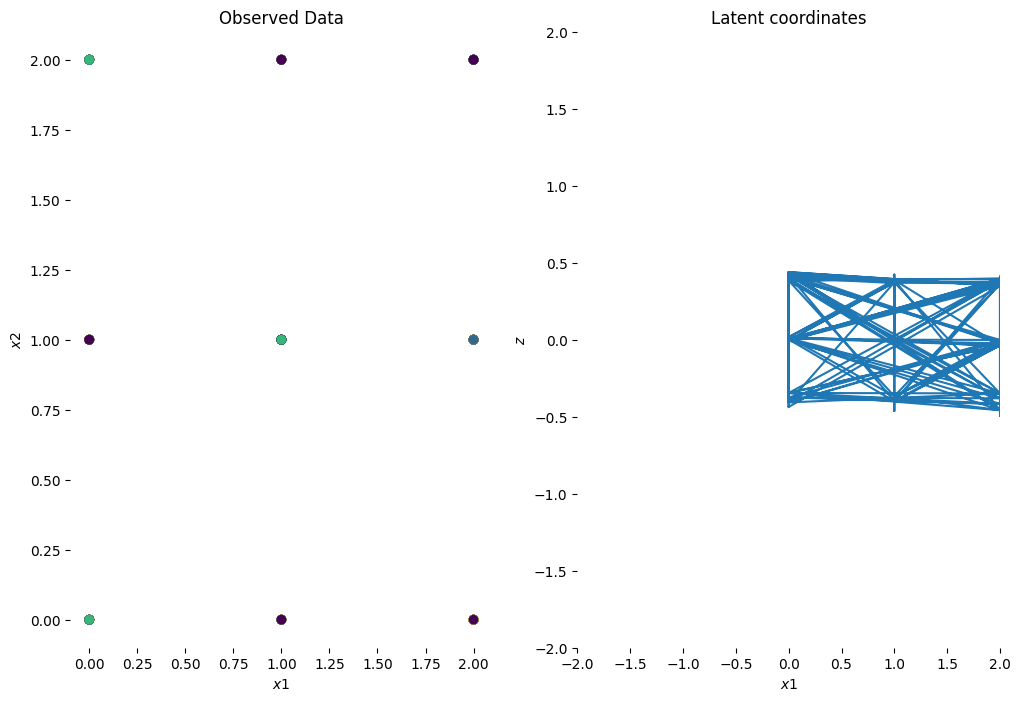

In [142]:
fig = plt.figure(figsize=(12,8), facecolor='white')
data_ax = fig.add_subplot(121, frameon=False)
latent_ax = fig.add_subplot(122, frameon=False)

kernel = rbf_kernel
#X0 = df_X.to_numpy()
df_X_full = pd.concat([df_X_train,df_X_test,df_X_syn])
X0 = df_X_full.to_numpy()
X = X0[:,:-1]

n,D = X.shape
d = 2
zero_mean = np.zeros(n)

init_params = np.random.normal(size=(n * d))

res = minimize(value_and_grad(objective), init_params, 
               jac=True, method='CG', options = {'maxiter':10000},
               callback = callback)

fitted_Zx = np.reshape(res.x, (n, d))


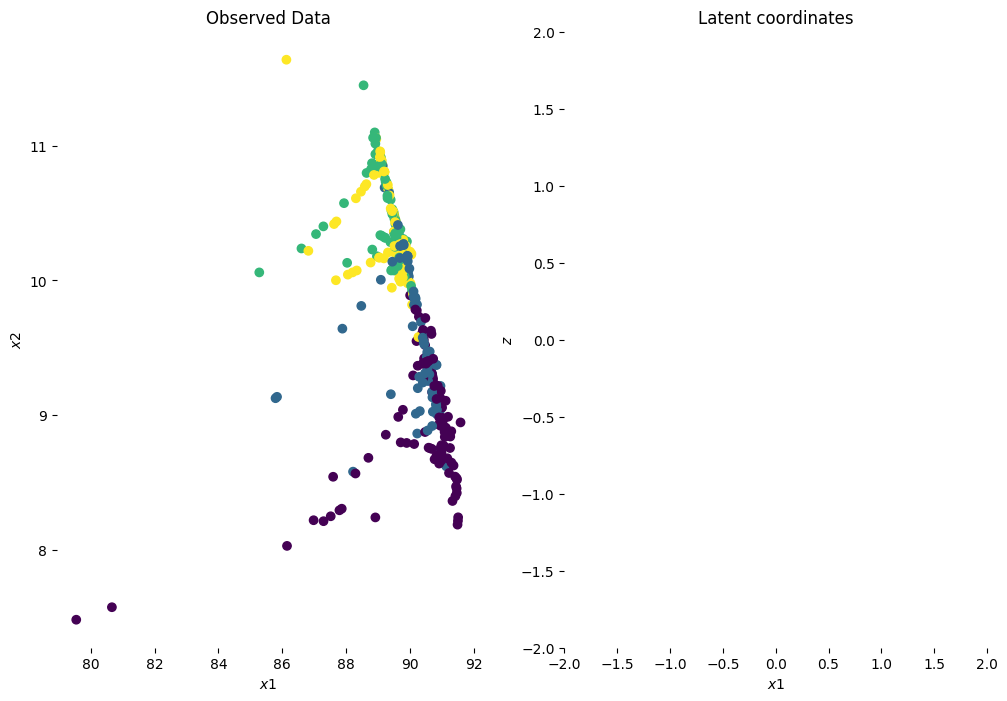

In [143]:
fig = plt.figure(figsize=(12,8), facecolor='white')
data_ax = fig.add_subplot(121, frameon=False)
latent_ax = fig.add_subplot(122, frameon=False)

kernel = rbf_kernel
df_y_full = pd.concat([df_y_train,df_y_test,df_y_syn.iloc[:,0:2]])
X = df_y_full.to_numpy()
#X = df_y
n,D = X.shape
d = 2
zero_mean = np.zeros(n)

init_params = np.random.normal(size=(n * d))

res = minimize(value_and_grad(objective), init_params, 
               jac=True, method='CG', options = {'maxiter':10000},
               callback = callback)

fitted_Zy = np.reshape(res.x, (n, d))


In [83]:
scaled_y_test = y_scaler.transform(df_y_test.to_numpy())
scaled_y_syn = y_scaler.transform(df_y_syn.iloc[:,:2].to_numpy())

fit_zx_scaler = MinMaxScaler()
fit_zy_scaler = MinMaxScaler()
scaled_fitted_Zx = fit_zx_scaler.fit_transform(fitted_Zx)

scaled_train_fitted_Zx = scaled_fitted_Zx[:len(df_X_train)]
scaled_test_fitted_Zx = scaled_fitted_Zx[len(df_X_train):len(df_x)]
scaled_syn_fitted_Zx = scaled_fitted_Zx[len(df_x):]

scaled_fitted_Zy = fit_zy_scaler.fit_transform(fitted_Zy)
scaled_train_fitted_Zy = scaled_fitted_Zy[:len(df_X_train)]
scaled_test_fitted_Zy = scaled_fitted_Zy[len(df_X_train):len(df_x)]
scaled_syn_fitted_Zy = scaled_fitted_Zy[len(df_x):]

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [86]:
df_y_syn.columns

Index(['UP_SEC_Monomer', 'UP_SEC_LMW', 'ei'], dtype='object')

In [88]:
df_y_syn.reset_index(inplace = True, drop = True)
buffer_type_idx = 0

ls_markers = [ "^" , "o", "*",',']

colors = ['r','g','b','y']
dict_markers = dict()
dict_colors = dict()


for i in range(num_tasks):
    dict_markers[i] = ls_markers[i]
    dict_colors[i] = colors[i]


#for i in range(n_buffer_level):
#    dict_colors[i] = colors[i]


#task_idx = 0
#syn plot df
df_X_syn.reset_index(inplace= True, drop = True)
#df_syn_plot = df_X_syn.copy()
df_syn_plot = df_X_syn[df_X_syn['Buffer_label']==buffer_type_idx]
df_syn_plot['marker'] = df_X_syn['task_ind'].map(dict_markers)
#df_syn_plot['marker'] = df_X_syn['Buffer_Type_label'].map(dict_markers)
#df_syn_plot['color']  = df_X_syn['task_ind'].map(dict_colors)
#df_syn_plot['color']  = df_X_syn['Sugar_Salt_label'].map(dict_colors)
df_syn_plot['e_color']  = df_X_syn['task_ind'].map(dict_colors)

df_syn_plot['f_color'] = df_syn_plot['e_color']
#df_syn_plot.loc[df_syn_plot.Additive_label != 0, 'f_color'] = 'w'


df_syn_plot['lx1']= scaled_syn_fitted_Zx[df_X_syn['Buffer_label']==buffer_type_idx, 0]
df_syn_plot['lx2']= scaled_syn_fitted_Zx[df_X_syn['Buffer_label']==buffer_type_idx, 1]


df_syn_plot['y1']= scaled_y_syn[df_X_syn['Buffer_label']==buffer_type_idx, 0]
df_syn_plot['y2']= scaled_y_syn[df_X_syn['Buffer_label']==buffer_type_idx, 1]

df_syn_plot['oy1']= df_y_syn.loc[df_X_syn['Buffer_label']==buffer_type_idx, 'UP_SEC_LMW']
df_syn_plot['oy2']= df_y_syn.loc[df_X_syn['Buffer_label']==buffer_type_idx, 'UP_SEC_Monomer']

df_syn_plot['ly1']= scaled_syn_fitted_Zy[df_X_syn['Buffer_label']==buffer_type_idx, 0]
df_syn_plot['ly2']= scaled_syn_fitted_Zy[df_X_syn['Buffer_label']==buffer_type_idx, 1]


"""
df_syn_plot['lx1']= scaled_syn_fitted_Zx[:, 0]
df_syn_plot['lx2']= scaled_syn_fitted_Zx[:, 1]

df_syn_plot['lxy1']= scaled_fitted_syn_Zxy[:,0]
df_syn_plot['lxy2']= scaled_fitted_syn_Zxy[:,1]

df_syn_plot['y1']= scaled_y_syn[:, 0]
df_syn_plot['y2']= scaled_y_syn[:, 1]

df_syn_plot['ly1']= scaled_syn_fitted_Zy[:, 0]
df_syn_plot['ly2']= scaled_syn_fitted_Zy[:, 1]
"""


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_97080/812368297.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_syn_plot['marker'] = df_X_syn['task_ind'].map(dict_markers)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_97080/812368297.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_syn_plot['e_color']  = df_X_syn['task_ind'].map(dict_colors)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_97080/812368297.py:31: SettingWithCopyWarning: 
A value is trying to b

"\ndf_syn_plot['lx1']= scaled_syn_fitted_Zx[:, 0]\ndf_syn_plot['lx2']= scaled_syn_fitted_Zx[:, 1]\n\ndf_syn_plot['lxy1']= scaled_fitted_syn_Zxy[:,0]\ndf_syn_plot['lxy2']= scaled_fitted_syn_Zxy[:,1]\n\ndf_syn_plot['y1']= scaled_y_syn[:, 0]\ndf_syn_plot['y2']= scaled_y_syn[:, 1]\n\ndf_syn_plot['ly1']= scaled_syn_fitted_Zy[:, 0]\ndf_syn_plot['ly2']= scaled_syn_fitted_Zy[:, 1]\n"

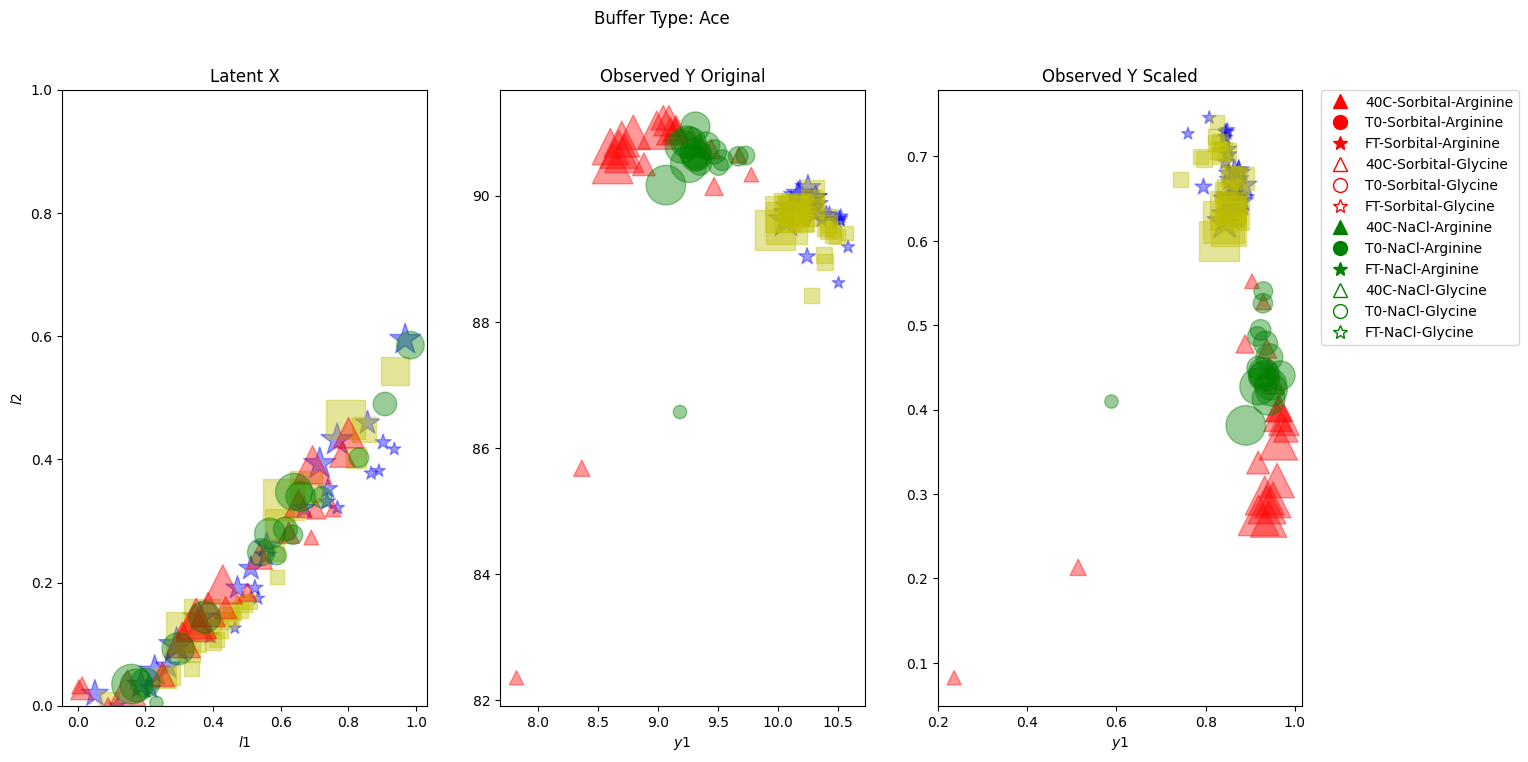

In [90]:
from matplotlib.lines import Line2D
custom = [Line2D([], [], marker=ls_markers[0], markersize=20, markerfacecolor=dict_colors[0], markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[1], markersize=20, markerfacecolor=dict_colors[0], markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[2], markersize=20, markerfacecolor=dict_colors[0], markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[0], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[1], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[2], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[0], linestyle='None'),
          Line2D([], [], marker=ls_markers[0], markersize=20, markerfacecolor=dict_colors[1], markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[1], markersize=20, markerfacecolor=dict_colors[1], markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[2], markersize=20, markerfacecolor=dict_colors[1], markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[0], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[1], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[1], linestyle='None'),
          Line2D([], [], marker=ls_markers[2], markersize=20, markerfacecolor='white', markeredgecolor=dict_colors[1], linestyle='None')]

fig = plt.figure(figsize=(16,8), edgecolor='black')

latent_ax1 = fig.add_subplot(131)
latent_ax2 = fig.add_subplot(132)
latent_ax3 = fig.add_subplot(133)


#s = np.power(np.exp(d['pH'].values),2)/10
#s = np.exp(d['pH'].values)
for marker, d in df_syn_plot.groupby('marker'):
    scatter1 = latent_ax1.scatter(x=d['lx1'], y=d['lx2'], edgecolors=d['e_color'], marker=marker,
                                  label = marker,
                       s = np.exp(d['pH'].values)*1,facecolors=d['f_color'],alpha = 0.4)

for marker, d in df_syn_plot.groupby('marker'):
    scatter2 = latent_ax2.scatter(x=d['oy1'], y=d['oy2'], edgecolors=d['e_color'], marker=marker, 
                       label = marker,
                       s = np.exp(d['pH'].values)*1,facecolors=d['f_color'],alpha = 0.4)

for marker, d in df_syn_plot.groupby('marker'):
    scatter3 = latent_ax3.scatter(x=d['y1'], y=d['y2'], edgecolors=d['e_color'], marker=marker,
                       label = marker,
                       s = np.exp(d['pH'].values)*1,facecolors=d['f_color'],alpha = 0.4)





latent_ax1.set_ylim(0,1)
latent_ax1.set_xlabel(r"$l1$")
latent_ax1.set_ylabel(r"$l2$")


latent_ax2.set_title('Observed Y Original')
latent_ax2.set_xlabel(r"$y1$")
#latent_ax2.set_ylabel(r"$y2$")
latent_ax2.set_ylabel('')

#latent_ax3.set_xlim(0,1)
#latent_ax3.set_ylim(0,1)
latent_ax3.set_xlabel(r"$y1$")
#latent_ax3.set_ylabel(r"$y2$")
latent_ax3.set_ylabel('')
latent_ax1.set_title('Latent X')
latent_ax3.set_title('Observed Y Scaled')


"""
latent_ax2.tick_params(
axis='y', # changes apply to the y-axis
which='both', # both major and minor ticks are affected
left=False, # ticks along the bottom edge are off
labelleft=False) # labels along the bottom edge are off



latent_ax3.tick_params(
axis='y', # changes apply to the y-axis
which='both', # both major and minor ticks are affected
left=False, # ticks along the bottom edge are off
labelleft=False
) # labels along the bottom edge are off
"""

"""
latent_ax3.legend(['40C','T0','FT'],
                  bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
                  markerscale=0.5)
"""


plt.legend(handles = custom,labels = ['40C-Sorbital-Arginine','T0-Sorbital-Arginine','FT-Sorbital-Arginine',
                                      '40C-Sorbital-Glycine','T0-Sorbital-Glycine','FT-Sorbital-Glycine',
                                      '40C-NaCl-Arginine','T0-NaCl-Arginine','FT-NaCl-Arginine',
                                      '40C-NaCl-Glycine','T0-NaCl-Glycine','FT-NaCl-Glycine'],
                  bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
                  markerscale=0.5)
#latent_ax3.add_artist(legend1)

"""
handles, labels = latent_ax3.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
                  markerscale=0.5)




# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter3.legend_elements(prop="sizes", alpha=0.6)
legend2 = latent_ax3.legend(handles, labels, loc="upper right", title="Sizes")
"""

#plt.draw()


fig.suptitle('Buffer Type: '+str(buffer_dict[buffer_type_idx]))

#plt.pause(1.0/60.0)
plt.show(block=False)
#plt.savefig(figPath+'/all-embeddings-scaled-syn.jpg')